### Recycling Robot

TD(0) policy-iteration for the Recycling Robot 

1) Defines the Recycling Robot MDP (H/L, search/wait/recharge).
2) Learns V(s) for a *current* policy π using full TD(0): 
       V(S_t) <- V(S_t) + α_lr [ R_{t+1} + γ V(S_{t+1}) - V(S_t) ]
3) Improves π via 1-step model lookahead using known (α, β, r_search, r_wait).
4) Repeats evaluate -> improve over epochs, logging per-epoch total reward.
5) Performs a light parameter sweep over (α, β, r_search, r_wait) to pick the best combo by mean total reward.
6) Saves logs to /mnt/data/rewards.txt and plots: rewards_curve.png, policy_heatmap.png.

Notes:
- Uses matplotlib.
- Keeps the sweep small by default to ensure it runs quickly here; you can expand grids later.

In [3]:
import numpy as np
import json
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Dict, Tuple, List

In [36]:
# -------------------- Config --------------------
CONFIG = {
    # Core TD/Training settings
    "gamma": 1,
    "td_lr": 0.1,                 # step-size α_lr for TD(0)
    "epochs": 100,                # number of policy-evaluation/improvement cycles
    "steps_per_epoch": 1000,      # steps per epoch (continuing task)
    "num_runs": 5,                # repeat runs to average per parameter combo
    "start_state": 0,             # 0=H, 1=L
    "epsilon": 0.05,              # small exploration during evaluation to improve coverage
    # Parameter sweep (keep it small for demo)
    "grid_alpha":  [0.6, 0.7],
    "grid_beta":   [0.4, 0.5],
    "grid_r_search": np.arange(3, 6, 1).tolist(),
    "grid_r_wait":   np.arange(1, 3, 1).tolist(),
    "rescue_penalty": -3.0,
    # Files
    "rewards_path": "rewards.txt",
    "best_params_path": "best_params.json",
    "rewards_fig": "rewards_curve.png",
    "policy_fig": "policy_heatmap.png",
    "seed": 1234,
}

In [37]:
STATE_H, STATE_L = 0, 1
A_SEARCH, A_WAIT, A_RECHARGE = 0, 1, 2
STATE_NAMES = ["high", "low"]
ACTION_NAMES = ["search", "wait", "recharge"]

rng_global = np.random.default_rng(CONFIG["seed"])

In [38]:
@dataclass
class MDPParams:
    alpha_prob: float
    beta_prob: float
    r_search: float
    r_wait: float
    rescue_penalty: float
    gamma: float

class RecyclingRobotEnv:
    def __init__(self, params: MDPParams, rng: np.random.Generator):
        self.p = params
        self.rng = rng

    @staticmethod
    def valid_actions(state: int) -> List[int]:
        return [A_SEARCH, A_WAIT] if state == STATE_H else [A_SEARCH, A_WAIT, A_RECHARGE]

    def step(self, state: int, action: int) -> Tuple[int, float]:
        if state == STATE_H:
            if action == A_SEARCH:
                r = self.p.r_search
                next_state = STATE_H if self.rng.random() < self.p.alpha_prob else STATE_L
                return next_state, r
            elif action == A_WAIT:
                return STATE_H, self.p.r_wait
            else:
                raise ValueError("Recharge invalid in HIGH")
        else:
            if action == A_SEARCH:
                if self.rng.random() < self.p.beta_prob:
                    return STATE_L, self.p.r_search
                else:
                    return STATE_H, self.p.rescue_penalty
            elif action == A_WAIT:
                return STATE_L, self.p.r_wait
            elif action == A_RECHARGE:
                return STATE_H, 0.0
            else:
                raise ValueError("Unknown action")

def lookahead_q(state: int, action: int, V: np.ndarray, p: MDPParams) -> float:
    """Compute Q(s,a) via the known model and current V (1-step lookahead)."""
    g = p.gamma
    if state == STATE_H:
        if action == A_SEARCH:
            # H->H (α, r_search), H->L (1-α, r_search)
            return p.r_search + g * (p.alpha_prob * V[STATE_H] + (1 - p.alpha_prob) * V[STATE_L])
        elif action == A_WAIT:
            return p.r_wait + g * V[STATE_H]
        else:
            return -np.inf  # invalid
    else:
        if action == A_SEARCH:
            # L->L (β, r_search), L->H (1-β, rescue_penalty)
            return p.beta_prob * (p.r_search + g * V[STATE_L]) + (1 - p.beta_prob) * (p.rescue_penalty + g * V[STATE_H])
        elif action == A_WAIT:
            return p.r_wait + g * V[STATE_L]
        elif action == A_RECHARGE:
            return 0.0 + g * V[STATE_H]

def improve_policy(V: np.ndarray, p: MDPParams) -> Dict[int, int]:
    """Greedy deterministic policy π(s)=argmax_a lookahead Q(s,a)."""
    pi = {}
    for s in [STATE_H, STATE_L]:
        valid = RecyclingRobotEnv.valid_actions(s)
        qs = [lookahead_q(s, a, V, p) for a in valid]
        best_a = valid[int(np.argmax(qs))]
        pi[s] = best_a
    return pi

def eval_policy_td(env: RecyclingRobotEnv, pi: Dict[int, int], V: np.ndarray, steps: int, lr: float, epsilon: float, start_state: int) -> float:
    """One epoch of TD(0) under policy pi (with small ε exploration). Returns total reward collected."""
    total_r = 0.0
    s = start_state
    for _ in range(steps):
        # ε-greedy around π to ensure coverage
        valid = env.valid_actions(s)
        if env.rng.random() < epsilon:
            a = env.rng.choice(valid)
        else:
            a = pi[s] if s in pi else valid[0]
        s_next, r = env.step(s, a)
        total_r += r
        td_target = r + env.p.gamma * V[s_next]
        V[s] += lr * (td_target - V[s])
        s = s_next
    return total_r

def run_td_policy_iteration(params: MDPParams, epochs: int, steps_per_epoch: int, lr: float, epsilon: float, runs: int, start_state: int, seed: int):
    """Return per-epoch rewards averaged over runs and the final greedy policy for the last run."""
    rewards_runs = []
    last_policy = None
    for run in range(runs):
        rng = np.random.default_rng(seed + run)
        env = RecyclingRobotEnv(params, rng)
        # init V(s)=0
        V = np.zeros(2, dtype=float)
        # start with an initial naive policy (e.g., wait everywhere where valid)
        pi = {STATE_H: A_WAIT, STATE_L: A_WAIT}
        per_epoch_rewards = []
        for _ in range(epochs):
            # TD evaluation
            total_r = eval_policy_td(env, pi, V, steps_per_epoch, lr, epsilon, start_state)
            per_epoch_rewards.append(total_r)
            # Greedy improvement via model lookahead
            pi = improve_policy(V, params)
        rewards_runs.append(np.array(per_epoch_rewards))
        last_policy = pi
    # aggregate
    rewards_runs = np.vstack(rewards_runs)  # (runs, epochs)
    mean = rewards_runs.mean(axis=0)
    std = rewards_runs.std(axis=0)
    return mean, std, last_policy

# -------------------- Sweep and train --------------------
def sweep_and_train(cfg):
    gamma = cfg["gamma"]
    td_lr = cfg["td_lr"]
    epochs = cfg["epochs"]
    steps_per_epoch = cfg["steps_per_epoch"]
    runs = cfg["num_runs"]
    start_state = cfg["start_state"]
    epsilon = cfg["epsilon"]
    rescue_penalty = cfg["rescue_penalty"]
    seed = cfg["seed"]

    grid_records = []  # to select best
    best = None

    # For logging to rewards.txt as a single CSV (run index is not preserved across sweep; we log the MEAN curve per combo)
    with open(cfg["rewards_path"], "w", encoding="utf-8") as f:
        f.write("combo,epoch,mean_reward,std_reward,alpha,beta,r_search,r_wait\n")

    combo_idx = 0
    for a in cfg["grid_alpha"]:
        for b in cfg["grid_beta"]:
            for rs in cfg["grid_r_search"]:
                for rw in cfg["grid_r_wait"]:
                    if rs <= rw:
                        continue  # enforce r_search > r_wait
                    params = MDPParams(alpha_prob=a, beta_prob=b, r_search=rs, r_wait=rw, rescue_penalty=rescue_penalty, gamma=gamma)
                    mean, std, last_policy = run_td_policy_iteration(
                        params, epochs, steps_per_epoch, td_lr, epsilon, runs, start_state, seed=seed+combo_idx*97
                    )
                    # Write curve to file (mean/std per epoch for this combo)
                    with open(cfg["rewards_path"], "a", encoding="utf-8") as f:
                        for ep, (m, s) in enumerate(zip(mean, std), start=1):
                            f.write(f"{combo_idx},{ep},{m:.6f},{s:.6f},{a},{b},{rs},{rw}\n")
                    # Score this combo by final mean reward (last epoch)
                    score = float(mean[-1])
                    rec = {
                        "idx": combo_idx,
                        "alpha": a, "beta": b, "r_search": rs, "r_wait": rw,
                        "score_last_epoch": score,
                        "policy": {STATE_NAMES[s]: ACTION_NAMES[a] for s, a in last_policy.items()},
                        "mean_curve": mean.tolist(),
                        "std_curve": std.tolist(),
                    }
                    grid_records.append(rec)
                    if (best is None) or (score > best["score_last_epoch"]):
                        best = rec
                    combo_idx += 1

    # Save best params
    with open(cfg["best_params_path"], "w", encoding="utf-8") as f:
        json.dump(best, f, indent=2)
    return grid_records, best

In [39]:
records, best = sweep_and_train(CONFIG)

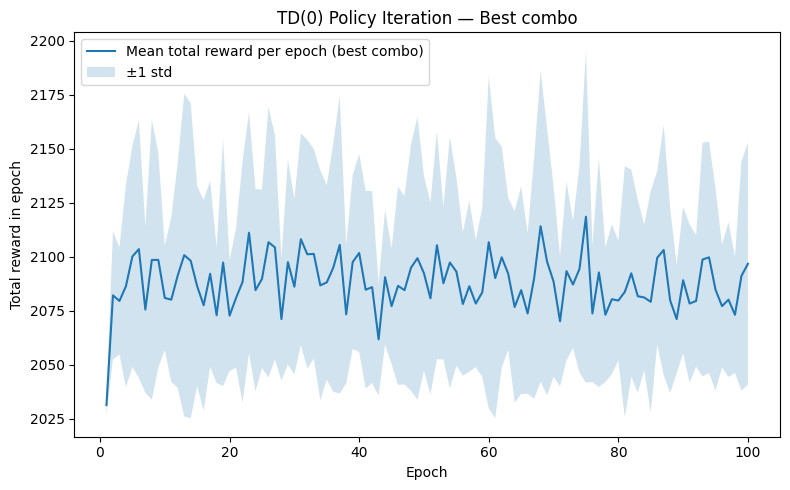

In [40]:
# -------------------- Plot rewards for the BEST combo --------------------
# Reconstruct mean/std arrays
mean_curve = np.array(best["mean_curve"])
std_curve = np.array(best["std_curve"])
epochs_axis = np.arange(1, CONFIG["epochs"] + 1)

plt.figure(figsize=(8,5))
plt.plot(epochs_axis, mean_curve, label="Mean total reward per epoch (best combo)")
plt.fill_between(epochs_axis, mean_curve-std_curve, mean_curve+std_curve, alpha=0.2, label="±1 std")
plt.xlabel("Epoch")
plt.ylabel("Total reward in epoch")
plt.title("TD(0) Policy Iteration — Best combo")
plt.legend()
plt.tight_layout()
plt.savefig(CONFIG["rewards_fig"])
# plt.close()

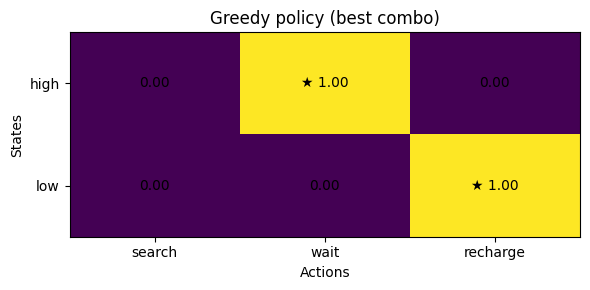

In [41]:
# -------------------- Policy heatmap for BEST combo --------------------
# Build a 2x3 matrix of policy action probabilities; greedy deterministic -> 1 for chosen action
policy_matrix = np.zeros((2,3), dtype=float)
for s_name, a_name in best["policy"].items():
    s_idx = STATE_NAMES.index(s_name)
    a_idx = ACTION_NAMES.index(a_name)
    policy_matrix[s_idx, a_idx] = 1.0

fig = plt.figure(figsize=(6,3))
ax = plt.gca()
im = ax.imshow(policy_matrix, aspect="auto")
ax.set_xticks(np.arange(3)); ax.set_yticks(np.arange(2))
ax.set_xticklabels(ACTION_NAMES); ax.set_yticklabels(STATE_NAMES)
plt.xlabel("Actions"); plt.ylabel("States"); plt.title("Greedy policy (best combo)")

# annotate
for i in range(2):
    for j in range(3):
        txt = "★ 1.00" if policy_matrix[i,j] == 1.0 else "0.00"
        ax.text(j, i, txt, ha="center", va="center")
plt.tight_layout()
plt.savefig(CONFIG["policy_fig"])
# plt.close()


In [42]:
(
    CONFIG["rewards_path"],
    CONFIG["best_params_path"],
    CONFIG["rewards_fig"],
    CONFIG["policy_fig"],
    best,
)

('rewards.txt',
 'best_params.json',
 'rewards_curve.png',
 'policy_heatmap.png',
 {'idx': 11,
  'alpha': 0.6,
  'beta': 0.5,
  'r_search': 5,
  'r_wait': 2,
  'score_last_epoch': 2096.8,
  'policy': {'high': 'wait', 'low': 'recharge'},
  'mean_curve': [2031.4,
   2082.2,
   2079.6,
   2086.4,
   2100.2,
   2103.6,
   2075.6,
   2098.6,
   2098.6,
   2081.0,
   2080.2,
   2091.4,
   2100.8,
   2098.2,
   2086.4,
   2077.6,
   2092.2,
   2073.0,
   2097.4,
   2072.8,
   2081.0,
   2088.4,
   2111.2,
   2084.6,
   2089.8,
   2106.8,
   2104.4,
   2071.2,
   2097.6,
   2086.2,
   2108.2,
   2101.2,
   2101.4,
   2086.8,
   2088.2,
   2095.0,
   2105.6,
   2073.4,
   2097.6,
   2101.8,
   2084.8,
   2086.0,
   2061.8,
   2090.6,
   2077.2,
   2086.6,
   2084.6,
   2095.0,
   2099.4,
   2092.4,
   2080.8,
   2105.4,
   2087.8,
   2097.4,
   2093.2,
   2078.2,
   2086.4,
   2078.4,
   2083.6,
   2106.8,
   2090.2,
   2099.8,
   2092.2,
   2076.8,
   2084.6,
   2073.8,
   2090.0,
   2114.2,
 

('rewards.txt',
 'best_params.json',
 'rewards_curve.png',
 'policy_heatmap.png',
 {'idx': 15,
  'alpha': 0.8,
  'beta': 0.7,
  'r_search': 1.2,
  'r_wait': 0.3,
  'score_last_epoch': 1009.9000000000152,
  'policy': {'high': 'search', 'low': 'recharge'},
  'mean_curve': [314.90000000000555,
   976.7000000000138,
   987.9000000000142,
   979.700000000014,
   973.8000000000137,
   983.6000000000141,
   982.7000000000143,
   990.9000000000143,
   976.7000000000138,
   991.0000000000142,
   990.8000000000143,
   975.7000000000136,
   986.8000000000142,
   1003.6000000000146,
   988.0000000000141,
   993.8000000000146,
   980.9000000000138,
   981.4000000000137,
   987.2000000000139,
   986.4000000000142,
   991.6000000000143,
   980.4000000000137,
   993.8000000000143,
   969.6000000000134,
   975.7000000000135,
   992.5000000000144,
   997.2000000000147,
   985.6000000000139,
   977.1000000000137,
   968.7000000000131,
   991.9000000000143,
   980.3000000000135,
   981.4000000000141,
   9

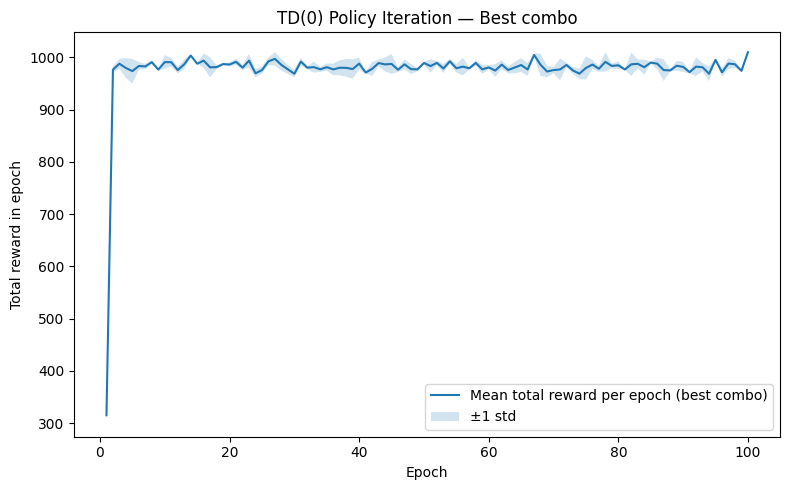

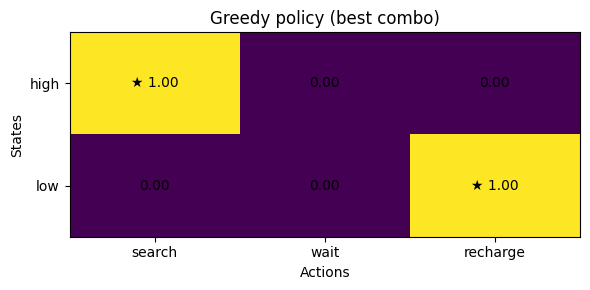

In [14]:
# Re-running the previous cell because the kernel state was reset.
import numpy as np
import json
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Dict, Tuple, List

CONFIG = {
    "gamma": 0.95,
    "td_lr": 0.1,
    "epochs": 100,
    "steps_per_epoch": 1000,
    "num_runs": 3,
    "start_state": 0,
    "epsilon": 0.05,
    "grid_alpha":  [0.7, 0.8],
    "grid_beta":   [0.5, 0.7],
    "grid_r_search": [1.0, 1.2],
    "grid_r_wait":   [0.1, 0.3],
    "rescue_penalty": -3.0,
    "rewards_path": "rewards.txt",
    "best_params_path": "best_params.json",
    "rewards_fig": "rewards_curve.png",
    "policy_fig": "policy_heatmap.png",
    "seed": 1234,
}

STATE_H, STATE_L = 0, 1
A_SEARCH, A_WAIT, A_RECHARGE = 0, 1, 2
STATE_NAMES = ["high", "low"]
ACTION_NAMES = ["search", "wait", "recharge"]

rng_global = np.random.default_rng(CONFIG["seed"])

from dataclasses import dataclass

@dataclass
class MDPParams:
    alpha_prob: float
    beta_prob: float
    r_search: float
    r_wait: float
    rescue_penalty: float
    gamma: float

class RecyclingRobotEnv:
    def __init__(self, params: MDPParams, rng: np.random.Generator):
        self.p = params
        self.rng = rng

    @staticmethod
    def valid_actions(state: int) -> List[int]:
        return [A_SEARCH, A_WAIT] if state == STATE_H else [A_SEARCH, A_WAIT, A_RECHARGE]

    def step(self, state: int, action: int) -> Tuple[int, float]:
        if state == STATE_H:
            if action == A_SEARCH:
                r = self.p.r_search
                next_state = STATE_H if self.rng.random() < self.p.alpha_prob else STATE_L
                return next_state, r
            elif action == A_WAIT:
                return STATE_H, self.p.r_wait
            else:
                raise ValueError("Recharge invalid in HIGH")
        else:
            if action == A_SEARCH:
                if self.rng.random() < self.p.beta_prob:
                    return STATE_L, self.p.r_search
                else:
                    return STATE_H, self.p.rescue_penalty
            elif action == A_WAIT:
                return STATE_L, self.p.r_wait
            elif action == A_RECHARGE:
                return STATE_H, 0.0
            else:
                raise ValueError("Unknown action")

def lookahead_q(state: int, action: int, V: np.ndarray, p: MDPParams) -> float:
    g = p.gamma
    if state == STATE_H:
        if action == A_SEARCH:
            return p.r_search + g * (p.alpha_prob * V[STATE_H] + (1 - p.alpha_prob) * V[STATE_L])
        elif action == A_WAIT:
            return p.r_wait + g * V[STATE_H]
        else:
            return -np.inf
    else:
        if action == A_SEARCH:
            return p.beta_prob * (p.r_search + g * V[STATE_L]) + (1 - p.beta_prob) * (p.rescue_penalty + g * V[STATE_H])
        elif action == A_WAIT:
            return p.r_wait + g * V[STATE_L]
        elif action == A_RECHARGE:
            return 0.0 + g * V[STATE_H]

def improve_policy(V: np.ndarray, p: MDPParams) -> Dict[int, int]:
    pi = {}
    for s in [STATE_H, STATE_L]:
        valid = RecyclingRobotEnv.valid_actions(s)
        qs = [lookahead_q(s, a, V, p) for a in valid]
        best_a = valid[int(np.argmax(qs))]
        pi[s] = best_a
    return pi

def eval_policy_td(env: RecyclingRobotEnv, pi: Dict[int, int], V: np.ndarray, steps: int, lr: float, epsilon: float, start_state: int) -> float:
    total_r = 0.0
    s = start_state
    for _ in range(steps):
        valid = env.valid_actions(s)
        if env.rng.random() < epsilon:
            a = env.rng.choice(valid)
        else:
            a = pi[s] if s in pi else valid[0]
        s_next, r = env.step(s, a)
        total_r += r
        td_target = r + env.p.gamma * V[s_next]
        V[s] += lr * (td_target - V[s])
        s = s_next
    return total_r

def run_td_policy_iteration(params: MDPParams, epochs: int, steps_per_epoch: int, lr: float, epsilon: float, runs: int, start_state: int, seed: int):
    rewards_runs = []
    last_policy = None
    for run in range(runs):
        rng = np.random.default_rng(seed + run)
        env = RecyclingRobotEnv(params, rng)
        V = np.zeros(2, dtype=float)
        pi = {STATE_H: A_WAIT, STATE_L: A_WAIT}
        per_epoch_rewards = []
        for _ in range(epochs):
            total_r = eval_policy_td(env, pi, V, steps_per_epoch, lr, epsilon, start_state)
            per_epoch_rewards.append(total_r)
            pi = improve_policy(V, params)
        rewards_runs.append(np.array(per_epoch_rewards))
        last_policy = pi
    rewards_runs = np.vstack(rewards_runs)
    mean = rewards_runs.mean(axis=0)
    std = rewards_runs.std(axis=0)
    return mean, std, last_policy

def sweep_and_train(cfg):
    gamma = cfg["gamma"]
    td_lr = cfg["td_lr"]
    epochs = cfg["epochs"]
    steps_per_epoch = cfg["steps_per_epoch"]
    runs = cfg["num_runs"]
    start_state = cfg["start_state"]
    epsilon = cfg["epsilon"]
    rescue_penalty = cfg["rescue_penalty"]
    seed = cfg["seed"]

    grid_records = []
    best = None

    with open(cfg["rewards_path"], "w", encoding="utf-8") as f:
        f.write("combo,epoch,mean_reward,std_reward,alpha,beta,r_search,r_wait\n")

    combo_idx = 0
    for a in cfg["grid_alpha"]:
        for b in cfg["grid_beta"]:
            for rs in cfg["grid_r_search"]:
                for rw in cfg["grid_r_wait"]:
                    if rs <= rw:
                        continue
                    params = MDPParams(alpha_prob=a, beta_prob=b, r_search=rs, r_wait=rw, rescue_penalty=rescue_penalty, gamma=gamma)
                    mean, std, last_policy = run_td_policy_iteration(
                        params, epochs, steps_per_epoch, td_lr, epsilon, runs, start_state, seed=seed+combo_idx*97
                    )
                    with open(cfg["rewards_path"], "a", encoding="utf-8") as f:
                        for ep, (m, s) in enumerate(zip(mean, std), start=1):
                            f.write(f"{combo_idx},{ep},{m:.6f},{s:.6f},{a},{b},{rs},{rw}\n")
                    score = float(mean[-1])
                    rec = {
                        "idx": combo_idx,
                        "alpha": a, "beta": b, "r_search": rs, "r_wait": rw,
                        "score_last_epoch": score,
                        "policy": {STATE_NAMES[s]: ACTION_NAMES[a] for s, a in last_policy.items()},
                        "mean_curve": mean.tolist(),
                        "std_curve": std.tolist(),
                    }
                    grid_records.append(rec)
                    if (best is None) or (score > best["score_last_epoch"]):
                        best = rec
                    combo_idx += 1

    with open(cfg["best_params_path"], "w", encoding="utf-8") as f:
        json.dump(best, f, indent=2)
    return grid_records, best

records, best = sweep_and_train(CONFIG)

# Plot rewards for the best combo
mean_curve = np.array(best["mean_curve"])
std_curve = np.array(best["std_curve"])
epochs_axis = np.arange(1, CONFIG["epochs"] + 1)

plt.figure(figsize=(8,5))
plt.plot(epochs_axis, mean_curve, label="Mean total reward per epoch (best combo)")
plt.fill_between(epochs_axis, mean_curve-std_curve, mean_curve+std_curve, alpha=0.2, label="±1 std")
plt.xlabel("Epoch")
plt.ylabel("Total reward in epoch")
plt.title("TD(0) Policy Iteration — Best combo")
plt.legend()
plt.tight_layout()
plt.savefig(CONFIG["rewards_fig"])
# plt.close()

# Policy heatmap for the best combo
policy_matrix = np.zeros((2,3), dtype=float)
for s_name, a_name in best["policy"].items():
    s_idx = STATE_NAMES.index(s_name)
    a_idx = ACTION_NAMES.index(a_name)
    policy_matrix[s_idx, a_idx] = 1.0

fig = plt.figure(figsize=(6,3))
ax = plt.gca()
im = ax.imshow(policy_matrix, aspect="auto")
ax.set_xticks(np.arange(3)); ax.set_yticks(np.arange(2))
ax.set_xticklabels(ACTION_NAMES); ax.set_yticklabels(STATE_NAMES)
plt.xlabel("Actions"); plt.ylabel("States"); plt.title("Greedy policy (best combo)")
for i in range(2):
    for j in range(3):
        txt = "★ 1.00" if policy_matrix[i,j] == 1.0 else "0.00"
        ax.text(j, i, txt, ha="center", va="center")
plt.tight_layout()
plt.savefig(CONFIG["policy_fig"])
# plt.close()

(
    CONFIG["rewards_path"],
    CONFIG["best_params_path"],
    CONFIG["rewards_fig"],
    CONFIG["policy_fig"],
    best,
)
